In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,7)

In [366]:
countries_mapping = {
    "134": "Germany",
    "111": "UnitedStates",
    "132": "France",
    "193": "Australia",
    "156": "Canada",
    "112": "UnitedKingdom",
    "122": "Austria",
    "124": "BelgiumLuxembourg",
    "138": "NetherlandsThe",
    "136": "Italy",
    "124": "Belgium",
    "128": "Denmark",
    "142": "Norway",
    "144": "Sweden",
    "146": "Switzerland",
    "158": "Japan",
    "174": "Greece",
    "172": "Finland",
    "184": "Spain",
    "178": "Ireland",
    "182": "Portugal",
    "196": "NewZealand"
}
list_countries = [
    'Australia', 'Austria', 'Canada', 'Denmark',
    'Finland', 'France', 'Germany', 'Greece',
    'Ireland', 'Italy', 'Japan', 'NewZealand',
    'Norway', 'Portugal', 'Spain', 'Sweden',
    'Switzerland', 'UnitedKingdom', 'UnitedStates'
]

In [367]:
def clean_trade_dataset(df):
    """
    Takes the df as provided by the imf and returns it as a clean and usable dataframe
    """
    df_transposed = df.iloc[5:,1:].T
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.iloc[1:, :]
    df_transposed.rename(columns={np.nan: "Year"}, inplace=True)
    df_transposed["Year"] = df_transposed["Year"].astype("int")
    df_transposed = df_transposed.set_index("Year")
    return df_transposed

def process_nominal_GDP(df):
    df = df.set_index("Year")
    df = df.replace("...", np.nan)
    for column in df.columns:
        df = df.astype({column:'float'})
    df = df.rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })
    return df.loc[1960:]

def process_real_GDP(df):
    df.columns = df.loc["Country"]
    df = (
        df
        .iloc[3:, ]
        .replace("...", np.nan)
        .rename(columns={
            "New Zealand": "NewZealand",
            "Netherlands, The": 'NetherlandsThe',
            "United States": "UnitedStates",
            "United Kingdom": "UnitedKingdom",
        })
    )

    for column in df.columns:
        df[column] = df[column].str.replace(" ","")
        df = df.astype({column:'float'})
    
    df = df.rename(columns={"Country": "date"})
    df["year"] = df.index.str[:4].astype(int)
    df["quarter"] = df.index.str[4:]
    df["month"] = df["quarter"].replace({"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10})
    df['date'] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.set_index("date")
    return df

def get_trade_activity(country_i, country_j):
    """
    Takes 2 countries as input
    Returns a dataframe with trade activity between these two countries
    X_i_j: export from country i to j
    X_i: total global export from country i
    M_i_j: import of country i from j
    M_i: total global import of country i
    Y_i: GDP of country i
    """
    X_i_j = dict_export[country_i][[country_j]].rename(columns={country_j: f"Export from {country_i} to {country_j}"})
    X_i = dict_export[country_i][["World"]].rename(columns={"World": f"Global Export from {country_i} to world"})
    X_j = dict_export[country_j][["World"]].rename(columns={"World": f"Global Export from {country_j} to world"})
    M_i_j = dict_import[country_i][[country_j]].rename(columns={country_j: f"Import of {country_i} from {country_j}"})
    M_i = dict_import[country_i][["World"]].rename(columns={"World": f"Global Import of {country_i}"})
    M_j = dict_import[country_j][["World"]].rename(columns={"World": f"Global Import of {country_j}"})
    Y_real_i = real_GDP_yearly[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_real_j = real_GDP_yearly[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    Y_nominal_i = nominalGDP[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_nominal_j = nominalGDP[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    W_i_j = pd.concat([X_i_j, X_i, M_i_j, M_i, X_j, M_j, Y_real_i, Y_real_j,Y_nominal_i, Y_nominal_j], axis=1)
    W_i_j["wt: Trade Intensity by bilateral trade"] = (X_i_j.values + M_i_j.values) / (X_i.values + X_j.values + M_i.values + M_j.values)
    W_i_j["wy_real: Trade Intensity by real GDP"] = (X_i_j.values + M_i_j.values) / (Y_real_i.values + Y_real_j.values)
    W_i_j["wy_nominal: Trade Intensity by nominal GDP"] = (X_i_j.values + M_i_j.values) / (Y_nominal_i.values + Y_nominal_j.values)
    W_i_j["wm"] = M_i_j.values / (M_i.values + M_j.values)
    W_i_j["wx"] = X_i_j.values / (X_i.values + X_j.values)
    for column in W_i_j.columns:
        W_i_j[column] = W_i_j[column].astype(float)
    return W_i_j

def get_average_period(df_trade_activity, date1, date2, country_i, country_j):
    ta_ci_cj = df_trade_activity[country_i][country_j]
    ta_ci_cj = ta_ci_cj[(ta_ci_cj.index >= date1) & (ta_ci_cj.index <= date2)]
    ta_ci_cj = ta_ci_cj.sort_index()
    return np.abs(pd.DataFrame(
                ta_ci_cj[["wt: Trade Intensity by bilateral trade",
                          "wy_real: Trade Intensity by real GDP",
                          "wy_nominal: Trade Intensity by nominal GDP",
                          "wm",
                          "wx"]]).loc[date1:date2].mean()).T

def process_concept_data(df):
    df = df[["Value", "TIME", "Country"]]
    df["Value"] = np.log(df["Value"])
    df["Year"] = df["TIME"].astype(str).str[:4]
    df["Quarter"] = df["TIME"].astype(str).str[-1].astype(int)
    df["Month"] = (df["Quarter"]-1)*3+1
    df['Date'] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
    return df

Process:
For the economic concepts (left side of regression equation: real GDP, employment, unemployment):
-> de-trend data with 4 methods (so far HP filter and 4th lag)
-> get correlation over each period between each pair of countries available)

For the bilateral trade intensity (right side of the regression equation, based on nominal GDP):
-> Get bilateral trade concept (wx, wm, wt) between each pair of countries available
-> Get average over each period


In [368]:
path_nominal_GDP = "data_StatApp/imf/NominalGDP.xls"
xls_nominalGDP = pd.ExcelFile(path_nominal_GDP)
nominalGDP = pd.read_excel(xls_nominalGDP, 'Sheet1')

path_real_GDP = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/imf/real_GDP_corrected.csv"
real_GDP = pd.read_csv(path_real_GDP, on_bad_lines='skip').T

In [369]:
real_GDP.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
Country,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,"China, P.R.: Hong Kong",Colombia,Costa Rica,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Ecuador,El Salvador,"Estonia, Rep. of",Euro Area,Finland,France,Germany,Greece,Honduras,Hungary,India,Indonesia,Ireland,Israel,Italy,Japan,Jordan,"Korea, Rep. of",Latvia,Lithuania,Luxembourg,Malta,Mexico,"Moldova, Rep. of","Netherlands, The",New Zealand,Norway,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Saudi Arabia,"Serbia, Rep. of",Singapore,Slovak Rep.,"Slovenia, Rep. of",South Africa,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,United Kingdom,United States
Scale,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions
Base Year,2004,2019/2020,2010,2010,1995,2010,2012,2018,2020,2015,2017,2010,2010,2010,2010,2007,2014,2010,2010,2010,2010,2010,2010,2000,2010,2011/2012,2010,2010,2015,2010,2015,NaN,2015,2010,2010,2010,2010,2013,2010,2010,2009/2010,2010,2018,2010,2010,2010,2016,2010,2010,2015,2010,2010,2015,2010,2010,2010,2005,2010,2016,2019,2012
1959Q1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,131 520.00,780 994.50
1959Q2,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,133 707.00,798 607.30


In [370]:
nominalGDP = process_nominal_GDP(nominalGDP)
real_GDP = process_real_GDP(real_GDP)
real_GDP_yearly = real_GDP.groupby("year").sum()

real_GDP_yearly = real_GDP_yearly.loc[1960:2020]

real_GDP_yearly = real_GDP_yearly.replace(0.0, np.nan)

real_GDP = real_GDP[list_countries]

real_GDP_yearly.head()

Country,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,"China, P.R.: Hong Kong",Colombia,Costa Rica,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Ecuador,El Salvador,"Estonia, Rep. of",Euro Area,Finland,France,Germany,Greece,Honduras,Hungary,India,Indonesia,Ireland,Israel,Italy,Japan,Jordan,"Korea, Rep. of",Latvia,Lithuania,Luxembourg,Malta,Mexico,"Moldova, Rep. of",NetherlandsThe,NewZealand,Norway,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Saudi Arabia,"Serbia, Rep. of",Singapore,Slovak Rep.,"Slovenia, Rep. of",South Africa,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,UnitedKingdom,UnitedStates,month
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,NaN,277471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29070100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576144.0,3262061.2,22
1961,NaN,277569.0,NaN,NaN,NaN,NaN,355591.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31086500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591529.0,3345690.3,22
1962,NaN,292573.0,NaN,NaN,NaN,NaN,381995.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32297200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,597893.0,3550683.8,22
1963,NaN,310885.0,NaN,NaN,NaN,NaN,402430.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35210600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,626797.0,3705317.8,22
1964,NaN,329918.0,NaN,NaN,NaN,NaN,429163.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38546500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662544.0,3918790.9,22


## Trade activity

#### For each country, aggregation of import and export with all other countries available

In [371]:

dict_paths = {}
dict_xls = {}
# dict export contains a set per country, representing the exports from this country to partners
dict_export = {}
# dict import contains a set per country, representing the imports of this country from partners
dict_import = {}

for country in list_countries:
    dict_paths[country] = f"data_StatApp/imf/trade/{country}.xls"
    dict_xls[country] = pd.ExcelFile(dict_paths[country])
    dict_export[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[0], index_col=None)
    dict_export[country] = clean_trade_dataset(dict_export[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand"
    })
    dict_export[country] = dict_export[country].T.drop_duplicates().T
    dict_import[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[1], index_col=None)
    dict_import[country] = clean_trade_dataset(dict_import[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand"
    })
    dict_import[country] = dict_import[country].T.drop_duplicates().T
    for column in dict_import[country].columns:
        dict_import[country][column] = dict_import[country][column].astype("float")
        dict_import[country][column] = dict_import[country][column].round(2)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (528008) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510643) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510790) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510833) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (529451) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size 

#### For each pair of countries, aggregate all the trade activity informations

In [372]:
trade_activity_countries = {}
for country_i in list_countries:
    trade_activity_countries[country_i] = {}
    for country_j in list_countries:
        if country_i != country_j:
            ta_ci_cj = dict()
            trade_activity_countries[country_i][country_j] = get_trade_activity(country_i, country_j)
            for month in [1, 4, 7, 10]:
                ta_ci_cj[month] = trade_activity_countries[country_i][country_j] / 4
                ta_ci_cj[month]["month"] = month
            trade_activity_countries[country_i][country_j] = pd.concat([ta_ci_cj[month] for month in [1, 4, 7, 10]])
            trade_activity_countries[country_i][country_j]['Date'] = pd.to_datetime(dict(year=trade_activity_countries[country_i][country_j].index, month=trade_activity_countries[country_i][country_j]["month"], day=1))
            trade_activity_countries[country_i][country_j] = trade_activity_countries[country_i][country_j].set_index("Date")
            

#### Aggregate all trading information in the same format as Frankel Rose data

In [373]:
dy_df = pd.DataFrame(columns=["country_1", "country_2", "period"])
trade_activity_countries_split = {}

for country_i in list_countries:
    trade_activity_countries_split[country_i] = {}
    for country_j in list_countries:
        if country_i != country_j:
            for (period, date1, date2) in [(1, "1959-01-01", "1967-07-01"), (2, "1967-10-01", "1976-04-01"), (3, "1976-07-01", "1985-01-01"), (4, "1985-04-01", "1993-10-01")]:
                df_countries_ij = pd.DataFrame(data={"country_1": [country_i], "country_2": [country_j], "period": [period]})
                df_countries_ij[["wt", "wy_real", "wy_nominal", "wm", "wx"]] = get_average_period(trade_activity_countries, date1, date2, country_i, country_j)[["wt: Trade Intensity by bilateral trade", "wy_real: Trade Intensity by real GDP", "wy_nominal: Trade Intensity by nominal GDP", "wm", "wx"]]
                dy_df = pd.concat([dy_df, df_countries_ij])


In [374]:
dy_df.head()

,country_1,country_2,period,wt,wy_real,wy_nominal,wm,wx
0,Australia,Austria,1,0.000370,NaN,NaN,0.000507,0.000212
0,Australia,Austria,2,0.000250,NaN,NaN,0.000420,0.000063
0,Australia,Austria,3,0.000206,NaN,NaN,0.000343,0.000045
0,Australia,Austria,4,0.000276,NaN,NaN,0.000464,0.000057
0,Australia,Canada,1,0.001956,0.000056,0.000555,0.002744,0.001119


### Comparison with Frankel Rose data

In [375]:
FR_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/Data_FrankelRose.csv"
FR_data = pd.read_csv(FR_data_path)

In [376]:
FR_data["count1"] = FR_data["count1"].astype(str)
FR_data["count2"] = FR_data["count2"].astype(str)
FR_data["count1"] = FR_data["count1"].replace(countries_mapping)
FR_data["count2"] = FR_data["count2"].replace(countries_mapping)
FR_data = FR_data.rename(columns={"count1": "country_1", "count2": "country_2"})

In [378]:
df_compare = pd.merge(FR_data[["period", "country_1", "country_2", "wx", "wm", "wt"]], dy_df, on=["period", "country_1", "country_2"])

df_compare["pairs"] = df_compare["country_1"] + "-" + df_compare["country_2"]

In [379]:
df_compare.head()

,period,country_1,country_2,wx_x,wm_x,wt_x,wt_y,wy_real,wy_nominal,wm_y,wx_y,pairs
0,1,UnitedStates,UnitedKingdom,0.063912,0.061481,0.062750,0.009723,0.000157,NaN,0.009435,0.009990,UnitedStates-UnitedKingdom
1,2,UnitedStates,UnitedKingdom,0.055754,0.049371,0.052393,0.008825,0.000255,NaN,0.008444,0.009244,UnitedStates-UnitedKingdom
2,3,UnitedStates,UnitedKingdom,0.058016,0.050574,0.053977,0.008264,0.000650,NaN,0.007643,0.009029,UnitedStates-UnitedKingdom
3,4,UnitedStates,UnitedKingdom,0.057168,0.042809,0.049051,0.008196,0.000922,NaN,0.007213,0.009486,UnitedStates-UnitedKingdom
4,1,UnitedStates,Austria,0.003921,0.004422,0.003986,0.000636,NaN,NaN,0.000711,0.000571,UnitedStates-Austria


In [380]:
dict_map_colors = dict()
n = df_compare["pairs"].unique().shape[0]

for pair in df_compare["pairs"].unique():
    a, b, c = np.random.random(1)[0], np.random.random(1)[0], np.random.random(1)[0]
    dict_map_colors[pair] = (a, b, c)

Each color represents a pair of countries

In [381]:
df_compare["wx_y"] = df_compare["wx_y"].fillna(0)
df_compare["wt_y"] = df_compare["wt_y"].fillna(0)

<AxesSubplot:xlabel='wt_x', ylabel='wt_y'>

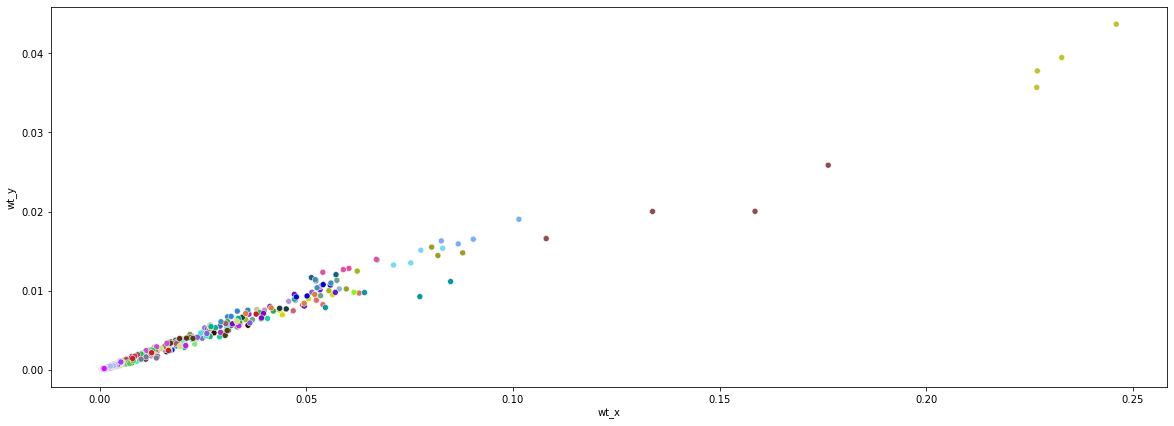

In [382]:
sns.scatterplot(data=df_compare, x="wt_x", y="wt_y", c=df_compare["pairs"].map(dict_map_colors))

<AxesSubplot:xlabel='wm_x', ylabel='wm_y'>

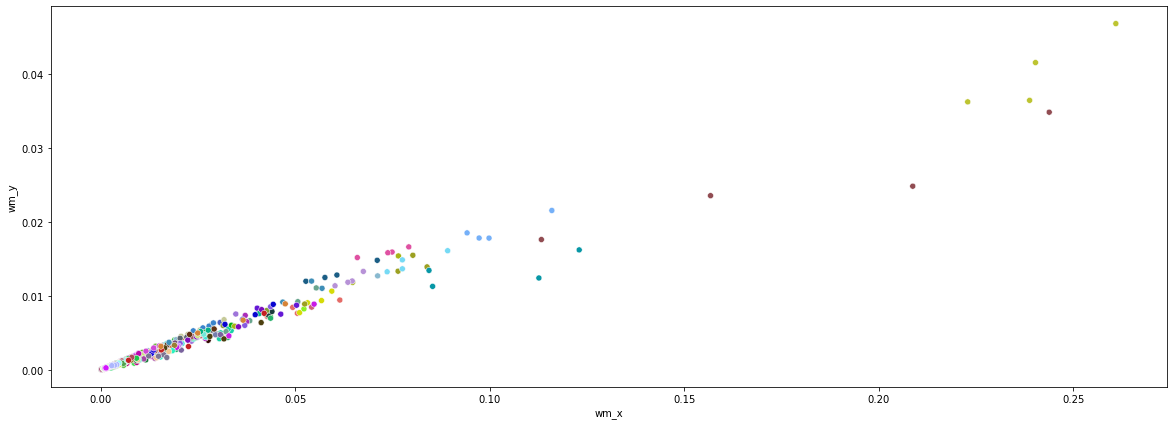

In [383]:
sns.scatterplot(data=df_compare, x="wm_x", y="wm_y", c=df_compare["pairs"].map(dict_map_colors))

<AxesSubplot:xlabel='wx_x', ylabel='wx_y'>

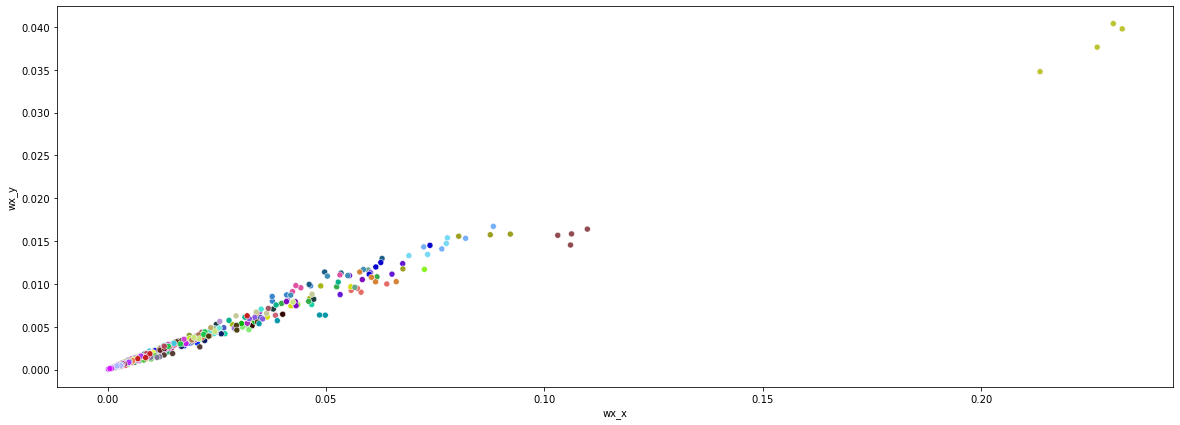

In [384]:
sns.scatterplot(data=df_compare, x="wx_x", y="wx_y", c=df_compare["pairs"].map(dict_map_colors))

#### Get correlation of data trends between processed data and Frankel Rose data

In [385]:
countries_corr = {}
for w in ["wt", "wm", "wx"]:
    countries_corr[str(w)] = dict()
    for i in range(len(list_countries)-1):
        country1 = list_countries[i]
        for j in range(i+1, len(list_countries)):
            country2 = list_countries[j]
            fr_df = FR_data[(FR_data["country_1"] == country1) & (FR_data["country_2"] == country2)][[w]]
            if fr_df.empty:
                fr_df = FR_data[(FR_data["country_1"] == country2) & (FR_data["country_2"] == country1)][[w]]
            dy_df_w = dy_df[(dy_df["country_1"] == country1) & (dy_df["country_2"] == country2)][[w]].fillna(0)
            countries_corr[str(w)][country1 + "_" + country2] = np.corrcoef(fr_df.values[:, 0], dy_df_w.values[:, 0])[0, 1]


#### average correlation between Frankel Rose data and processed data over all pairs of countries

In [386]:
print(f"average correlation on wt Trade Intensity by bilateral trade: {np.mean(list(countries_corr['wt'].values()))}")
print(f"average correlation on wm Trade Intensity by import: {np.mean(list(countries_corr['wx'].values()))}")
print(f"average correlation on wx Trade Intensity by export: {np.mean(list(countries_corr['wm'].values()))}")


average correlation on wt Trade Intensity by bilateral trade: 0.8734309524956154
average correlation on wm Trade Intensity by import: 0.5530165291321921
average correlation on wx Trade Intensity by export: 0.6425761034768724


## Analysis of economic concept data

In [500]:
def get_aggregation_countries(df):
    df_aggregate = pd.DataFrame({"date": real_GDP.index})
    for country in list_countries:
        df_country = df[df["Country"] == country][["Date", "Value"]].rename(columns={"Value": country, "Date": "date"})
        df_aggregate = pd.merge(df_aggregate, df_country, on="date", how="left")
    return df_aggregate

def get_hp(df):
    df_hp = pd.DataFrame()
    for country in list_countries:
        df_hp[country] = sm.tsa.filters.hpfilter(df[country].dropna(), 1600)[0]
    return df_hp

def get_concept_corr(df, name):
    corr_df = pd.DataFrame(columns=["period", "country_1", "country_2", name])
    nb_countries = len(list_countries)
    periods = [
        (1, "1959-01-01", "1967-07-01"),
        (2, "1967-10-01", "1976-04-01"),
        (3, "1976-07-01", "1985-01-01"),
        (4, "1985-04-01", "1993-10-01")
    ]
    index_increment = 0
    for i in range(nb_countries):
        for j in range(i+1, nb_countries):
            for (period, date1, date2) in periods:
                country_i = df.columns[i]
                country_j = df.columns[j]
                corr = df.loc[date1: date2][country_i].corr(df.loc[date1: date2][country_j])
                corr_df.loc[index_increment] = [period, country_i, country_j, corr]
                index_increment+=1
    return corr_df


### Employment data

In [501]:
employment_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/Employment.csv"
employment = pd.read_csv(employment_data_path)
employment = employment[employment["Subject"] == 'Employed population, Aged 15 and over, All persons']
employment["Country"] = employment["Country"].replace({
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })

In [502]:
employment = process_concept_data(employment)

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [503]:
employment = get_aggregation_countries(employment)

In [504]:
employment = employment.set_index("date")
employment_diff = employment.diff(4)

In [505]:
employment_hp = get_hp(employment)

In [506]:
corr_emp_hp = get_concept_corr(employment_hp, "se")
corr_emp_df = get_concept_corr(employment_diff, "de")
corr_emp = get_concept_corr(employment, "e")

### Unemployment data

In [531]:
path_unemployment = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/UnemployedPopulation.csv"
unemploy = pd.read_csv(path_unemployment)
unemploy = unemploy[unemploy["Subject"] == 'Unemployed population, Aged 15 and over, All persons']
unemploy["Country"] = unemploy["Country"].replace({
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })

In [532]:
unemploy = process_concept_data(unemploy)

unemploy = get_aggregation_countries(unemploy).set_index("date")



/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/3632107266.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [533]:
unemploy_diff = unemploy.diff(4)

unemploy_hp = get_hp(unemploy)

In [534]:
corr_unemp_hp = get_concept_corr(unemploy_hp, "su")
corr_unemp_df = get_concept_corr(unemploy_diff, "du")
corr_unemp = get_concept_corr(unemploy, "u")

## Real GDP

In [535]:
real_GDP_diff = real_GDP.diff(4)
real_GDP_hp = get_hp(real_GDP)

In [536]:
corr_real_GDP_hp = get_concept_corr(real_GDP_hp, "sy")
corr_real_GDP_df = get_concept_corr(real_GDP_diff, "dy")
corr_real_GDP = get_concept_corr(real_GDP, "y")

## Concatenation of all attributes

In [537]:
corr = pd.merge(corr_emp_hp, corr_emp_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_emp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp_hp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP_hp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, dy_df, on=["period", "country_1", "country_2"])

In [548]:
corr.to_csv("data_StatApp/processed_Data.csv")

In [541]:
compare2 = pd.merge(FR_data[["period", "country_1", "country_2", "se", "de", "du", "su", "dy", "sy", "wt", "wm", "wx"]], corr, on = ["period", "country_1", "country_2"])


In [542]:
compare2

,period,country_1,country_2,se_x,de_x,du_x,su_x,dy_x,sy_x,wt_x,wm_x,wx_x,se_y,de_y,e,du_y,su_y,u,sy_y,dy_y,y,wt_y,wy_real,wy_nominal,wm_y,wx_y
0,1,Austria,Denmark,0.774892,0.776907,0.583655,0.562033,-0.741937,-0.279533,0.006266,0.005094,0.006952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001279,NaN,NaN,0.001069,0.001541
1,2,Austria,Denmark,0.758608,0.637991,0.722838,0.679858,0.455120,0.311238,0.009182,0.006743,0.012473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001855,NaN,NaN,0.001415,0.002414
2,3,Austria,Denmark,0.134603,0.103567,0.349523,0.598995,0.352662,0.678432,0.006140,0.004599,0.008178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001246,NaN,NaN,0.000938,0.001637
3,4,Austria,Denmark,-0.024263,-0.381224,0.216841,-0.066874,0.005491,-0.633668,0.005746,0.005146,0.006429,0.735753,0.80126,-0.811034,0.790834,0.899561,0.941691,NaN,NaN,NaN,0.001183,NaN,NaN,0.001069,0.001311
4,1,Austria,France,0.024493,-0.252782,0.658234,0.513828,0.851275,-0.124666,0.007480,0.010194,0.004057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001268,NaN,NaN,0.001740,0.000769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,4,Portugal,Spain,0.724435,0.666799,0.741576,0.739564,0.732539,0.721674,0.037813,0.042037,0.031936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007070,NaN,NaN,0.007637,0.006271
336,1,Australia,NewZealand,NaN,NaN,NaN,NaN,0.021914,0.388540,0.035287,0.015500,0.057729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007148,NaN,NaN,0.003178,0.011386
337,2,Australia,NewZealand,0.455302,0.334186,0.628931,0.370365,0.286953,0.420573,0.041433,0.024968,0.060412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007859,NaN,NaN,0.004969,0.010765
338,3,Australia,NewZealand,0.432491,0.514350,0.632957,0.591971,0.241872,0.087534,0.049440,0.036635,0.066066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008435,NaN,NaN,0.006712,0.010260


<AxesSubplot:xlabel='dy_x', ylabel='dy_y'>

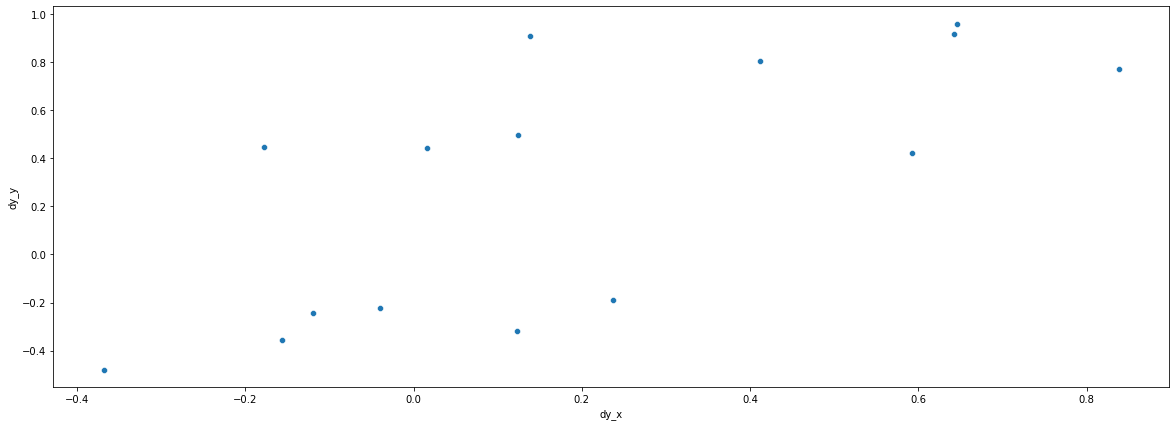

In [543]:
sns.scatterplot(data=compare2, x="dy_x", y="dy_y")

<AxesSubplot:xlabel='de_x', ylabel='de_y'>

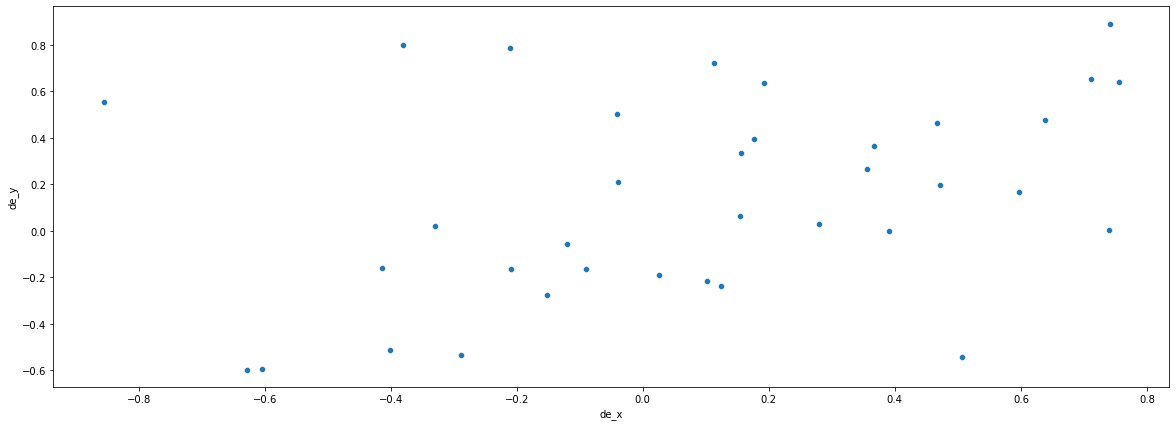

In [545]:
sns.scatterplot(data=compare2, x="de_x", y="de_y")

<AxesSubplot:xlabel='su_x', ylabel='su_y'>

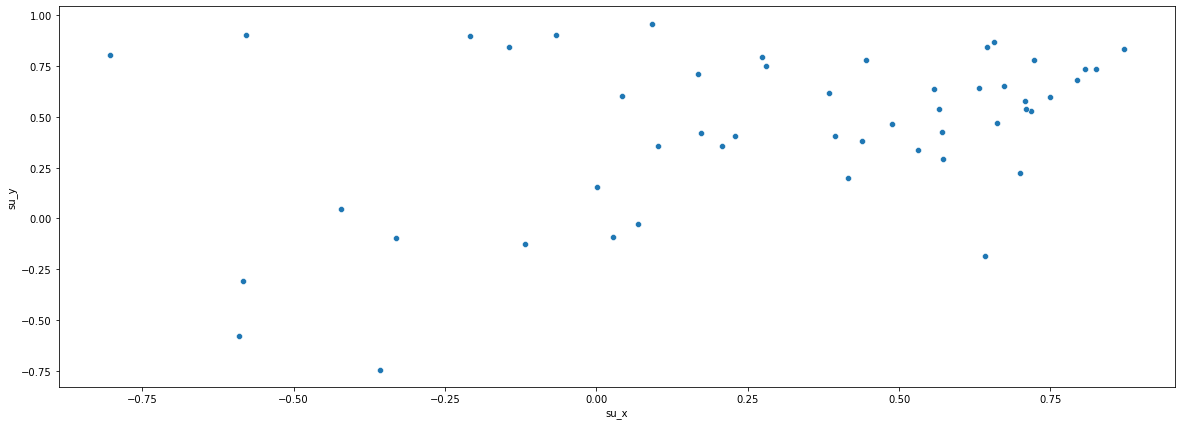

In [546]:
sns.scatterplot(data=compare2, x="su_x", y="su_y")